In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
from tqdm import tqdm
import seaborn as sns
from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import data_quality_checks

# Step0

Move global variables to a separate util file and can be changed for future parameter changes

In [4]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'
CURRENT_MONTH = '2022-01'

In [5]:
company_identifier_list = ['RA','HPCC','SFVPC','EMA','EMF','EMM','EMT','GRG','ST','EL']

# Step1

1. Create functions to first extract every company's incoming and outgoing transaction data
2. Find the cost per unit for each sale 
3. Find the mean/var for each product category (verifying distributions via histgram plots) 
4. Group by product category and plot boxplot for each category (separate or combined by company)
5. Group by state and product category and boxplot (separate or combined by company)
6. Group by month and product category and plot line plot with 95% CI shades over time

In [6]:
def fetch_data(company_identifier,transfer_packages_start_date,sales_transactrions_start_date,current_month):
    df_in,df_sales_deduped,bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts = data_quality_checks.run(company_identifier,transfer_packages_start_date,sales_transactrions_start_date)    
    return df_in,df_sales_deduped
    

In [29]:
###test out
incoming_transfer_data,sales_transaction_deduped = fetch_data(tuple(company_identifier_list),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,CURRENT_MONTH)


c:\users\roy luo\appdata\local\programs\python\python38\lib\site-packages\google\cloud\bigquery\client.py:535: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


Verifying download summaries for license C10-0000596-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-23

Verifying download summaries for license C10-0000774-LIC...
Earliest download summary: 2021-10-12
Latest download summary: 2022-02-23

Verifying download summaries for license C9-0000323-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-23

Verifying download summaries for license C9-0000370-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-23

Verifying download summaries for license C10-0000005-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-23

Verifying download summaries for license C10-0000064-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-23

Verifying download summaries for license C10-0000169-LIC...
Earliest download summary: 2020-01-01
Latest download summary: 2022-02-23

Verifying download summaries for license C10-0000408-LIC.

In [30]:
sales_transaction_deduped.sort_values('sales_datetime', inplace=True)

In [31]:
sales_transaction_deduped.head()

,license_number,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price
2998033,C10-0000064-LIC,0005126708,inactive,Consumer,2020-01-01 10:06:01+00:00,2020-01,1,32.48,inactive,1579580,1A406030000390D000005305,MAAD223191 Trainwreck Hybrid .5G Cart 7017-A,Vape Cartridge (volume - each),Each,1.0,32.48
2998031,C10-0000064-LIC,0005126709,inactive,Consumer,2020-01-01 10:06:06+00:00,2020-01,1,18.39,inactive,1725816,1A4060300004F59000003337,Bulk Eighth Brother Blue Dream,Flower,Grams,3.5,18.39
2998029,C10-0000064-LIC,0005126700,inactive,Consumer,2020-01-01 10:08:04+00:00,2020-01,1,18.39,inactive,1725816,1A4060300004F59000003337,Bulk Eighth Brother Blue Dream,Flower,Grams,3.5,18.39
2998027,C10-0000064-LIC,0005126711,inactive,Consumer,2020-01-01 10:08:51+00:00,2020-01,1,29.79,inactive,1576743,1A4060300005276000002017,StrongAg CoastalSun Banjo Packed 1/8,Flower,Grams,3.5,29.79
2998024,C10-0000064-LIC,0005126710,inactive,Consumer,2020-01-01 10:10:40+00:00,2020-01,2,63.31,inactive,1627757,1A4060300006D00000001296,The Cure Company - MARATHON OG - 3.5g - Marath...,Flower,Grams,3.5,45.72


In [32]:
sales_transaction_deduped.dtypes

license_number                           object
receipt_number                           object
rt_type                                  object
sales_customer_type                      object
sales_datetime              datetime64[ns, UTC]
sales_month                              object
total_packages                            int64
rt_total_price                          float64
tx_type                                  object
tx_package_id                            object
tx_package_label                         object
tx_product_name                          object
tx_product_category_name                 object
tx_unit_of_measure                       object
tx_quantity_sold                        float64
tx_total_price                          float64
dtype: object

In [33]:
sales_transaction_deduped.shape

(2541018, 16)

In [34]:
sales_transaction_deduped.tx_product_category_name.value_counts()

Flower (packaged eighth - each)        553992
Edible (weight - each)                 352894
Vape Cartridge (volume - each)         272641
Pre-Roll Flower                        264984
Vape Cartridge (weight - each)         249084
Flower                                 176671
Extract (weight - each)                163582
Pre-Roll Infused                       145759
Pre-Roll Leaf                          100799
Other Concentrate (weight - each)       59663
Edible (volume - each)                  35063
Flower (packaged half ounce - each)     32061
Flower (packaged quarter - each)        28536
Flower (packaged gram - each)           21897
Tincture (volume - each)                18756
Flower (packaged ounce - each)          15538
Flower (packaged - each)                 8455
Topical (weight - each)                  7671
Shake (Packaged Eighth - each)           6543
Capsule (weight - each)                  6124
Topical (volume - each)                  5677
Shake (Packaged Quarter - each)   

In [ ]:
sales_transaction_deduped.groupby('tx_product_category_name')['tx_total_price'].agg('sum')

In [35]:
sales_transaction_deduped.sales_customer_type.value_counts()

Consumer     2389223
Patient       151767
Caregiver         28
Name: sales_customer_type, dtype: int64

In [36]:
sales_transaction_deduped['tx_price_per_unit'] = sales_transaction_deduped.tx_total_price / sales_transaction_deduped.tx_quantity_sold
sales_transaction_deduped['date_in_month'] = sales_transaction_deduped.sales_datetime.dt.strftime('%Y-%m')


c:\users\roy luo\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tx_price_per_unit'>

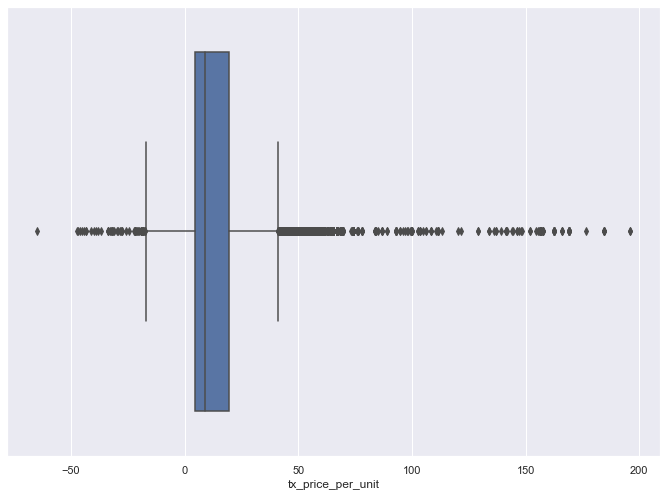

In [37]:
sns.boxplot(sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == 'Pre-Roll Flower']['tx_price_per_unit'])

<AxesSubplot:xlabel='tx_price_per_unit', ylabel='tx_product_category_name'>

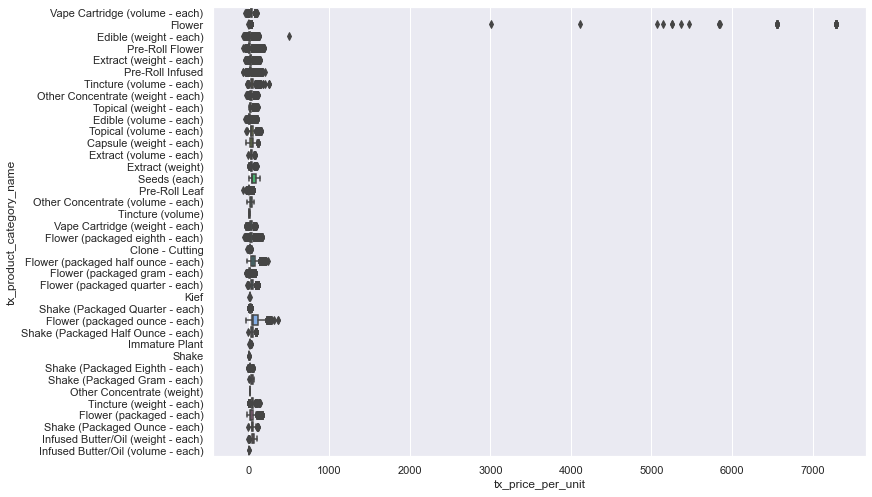

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y="tx_product_category_name", x="tx_price_per_unit", data=sales_transaction_deduped, orient = 'h')


Total number of transactions: 264984
Number of transactions outliers below Boxplot Whisker Minimum is 0.0003207740844730248 %
Number of transactions outliers above Boxplot Whisker Maximum is 0.11786749388642333 %


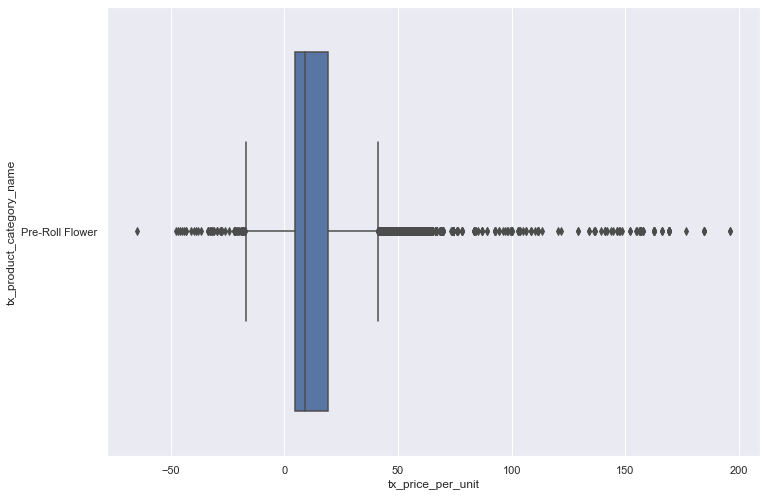

In [39]:
temp_df = sales_transaction_deduped[sales_transaction_deduped['tx_product_category_name'] == 'Pre-Roll Flower']
sns.boxplot(y="tx_product_category_name", x="tx_price_per_unit", data=temp_df, orient = 'h')

median = temp_df.tx_price_per_unit.median()
q1 = temp_df.tx_price_per_unit.quantile(.25)
q3 = temp_df.tx_price_per_unit.quantile(.75)
iqr = q3 - q1
maxx = median + iqr * 1.5
minn = median - iqr * 1.5

print("Total number of transactions: {}".format(temp_df.shape[0]))
print("Number of transactions outliers below Boxplot Whisker Minimum is {} %".format((temp_df.tx_price_per_unit < minn).mean()))
print("Number of transactions outliers above Boxplot Whisker Maximum is {} %".format((temp_df.tx_price_per_unit > maxx).mean()))

Vape Cartridge (volume - each)
272641


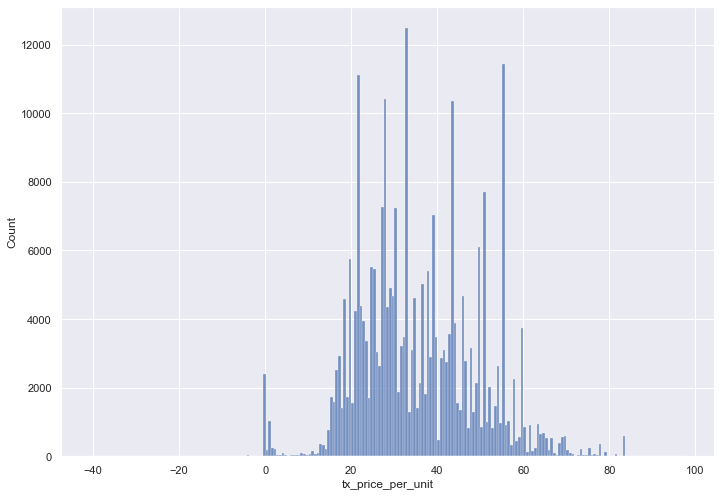

Flower
176671


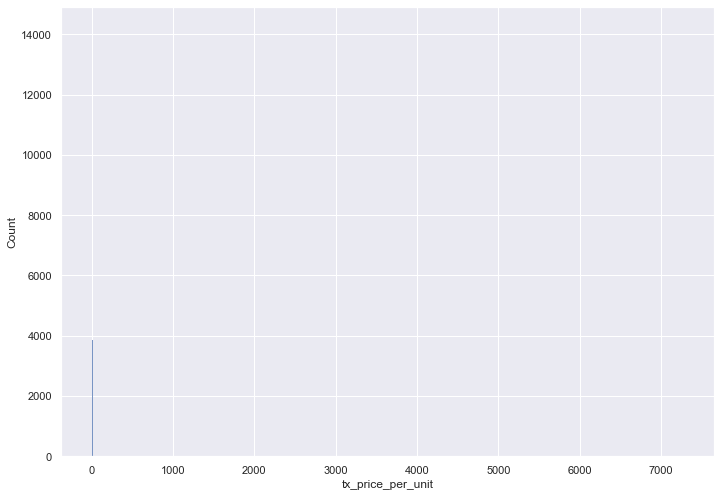

Edible (weight - each)
352894


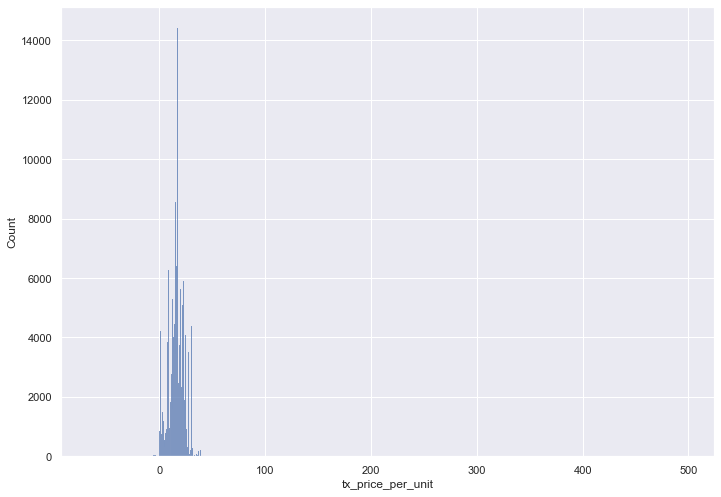

Pre-Roll Flower
264984


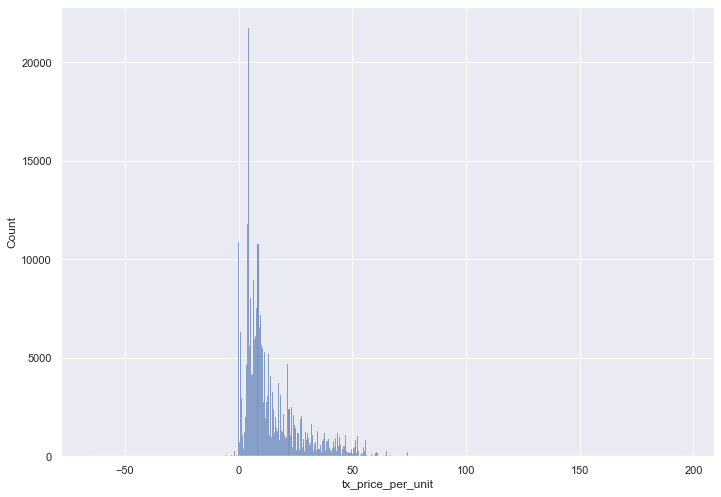

Extract (weight - each)
163582


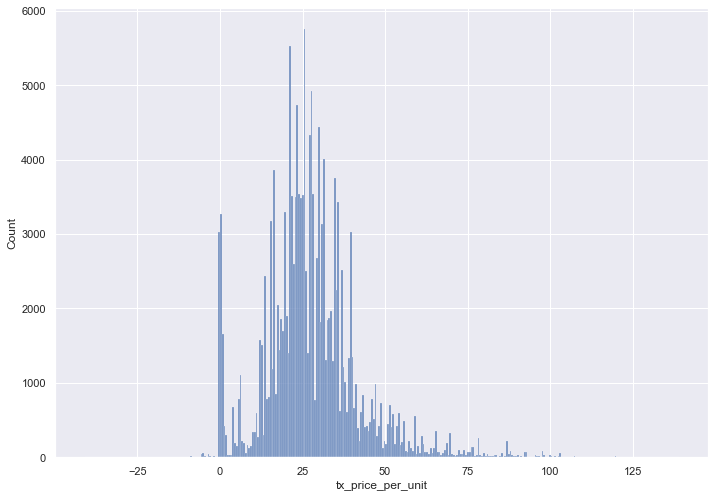

Pre-Roll Infused
145759


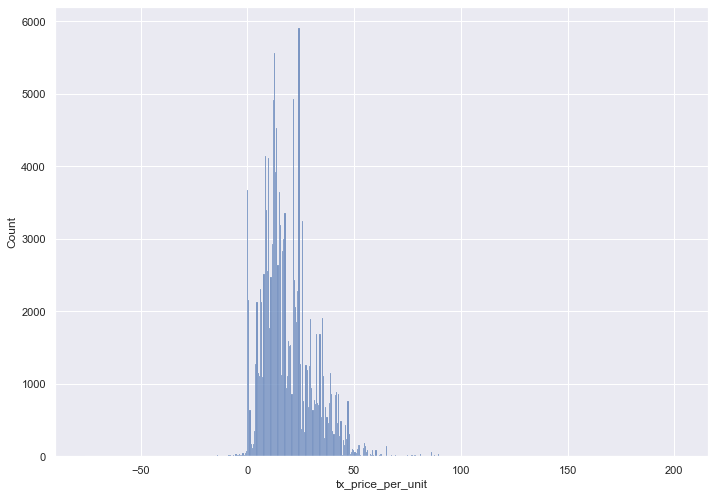

Tincture (volume - each)
18756


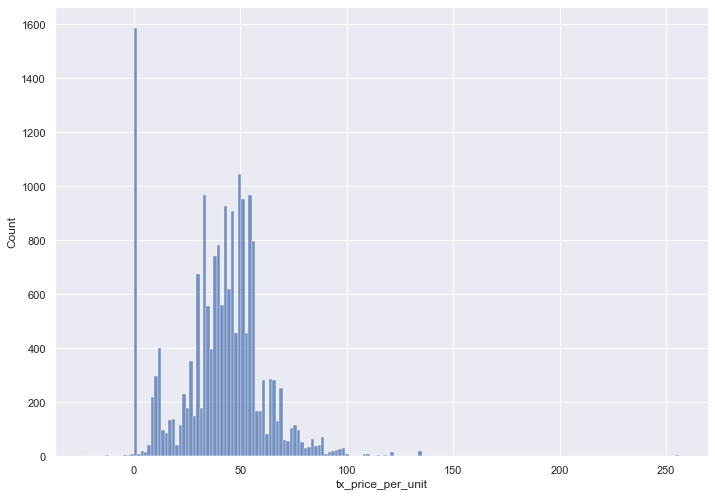

Other Concentrate (weight - each)
59663


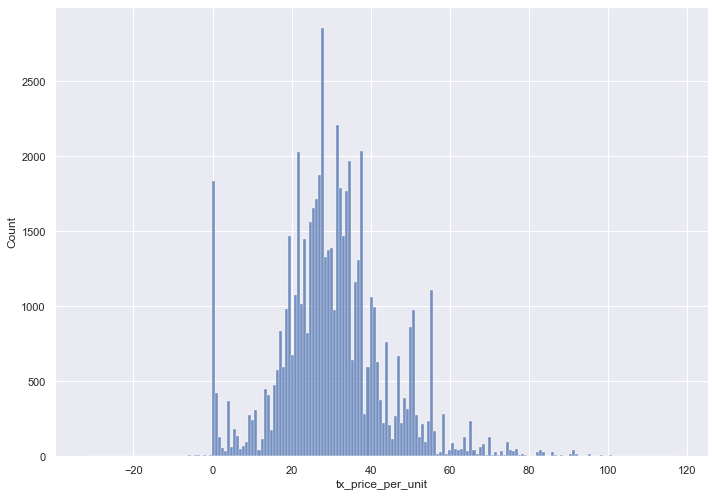

Topical (weight - each)
7671


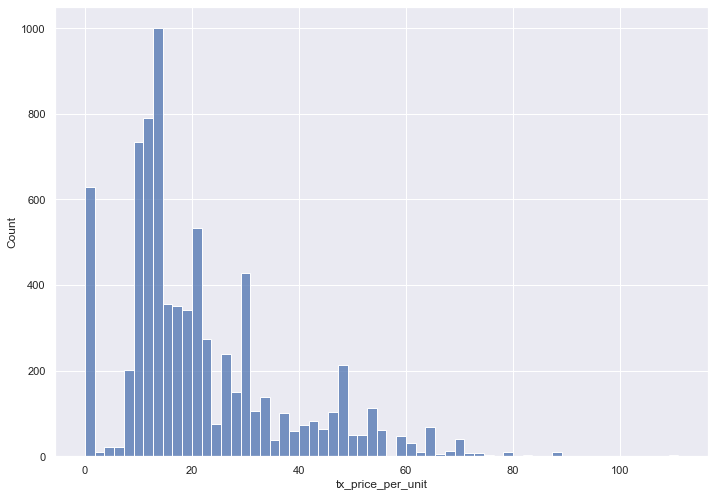

Edible (volume - each)
35063


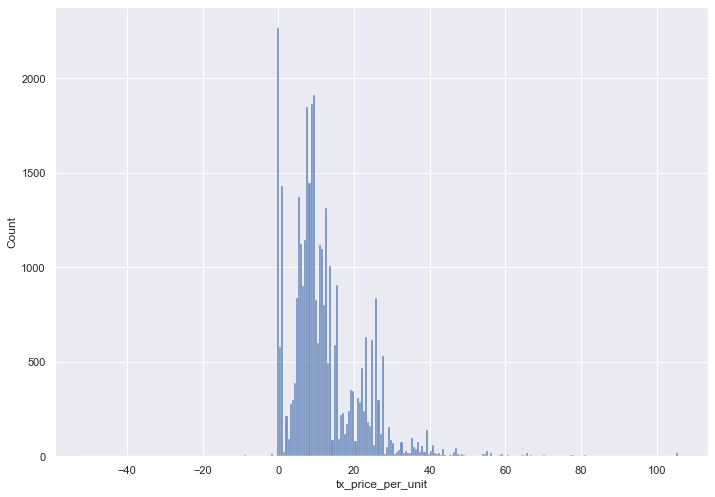

Topical (volume - each)
5677


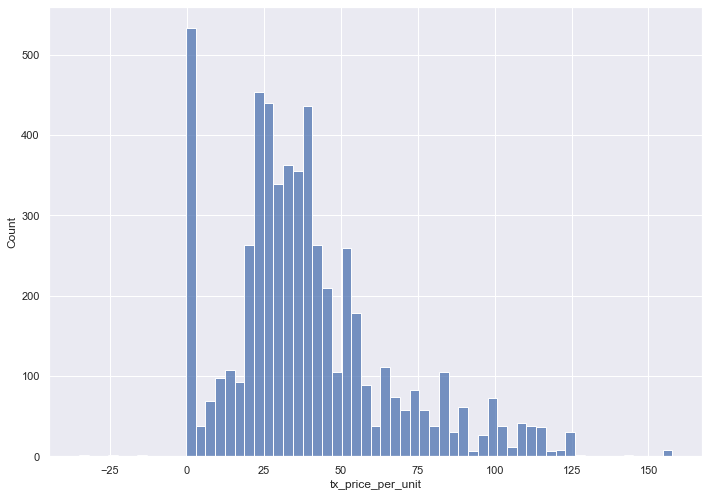

Capsule (weight - each)
6124


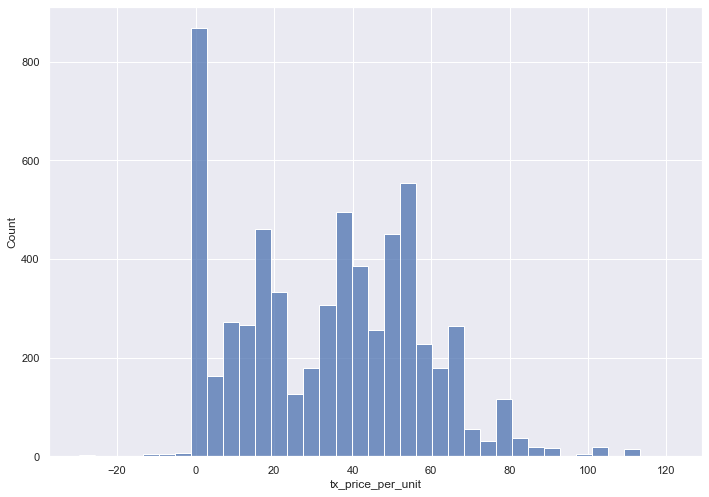

Extract (volume - each)
880


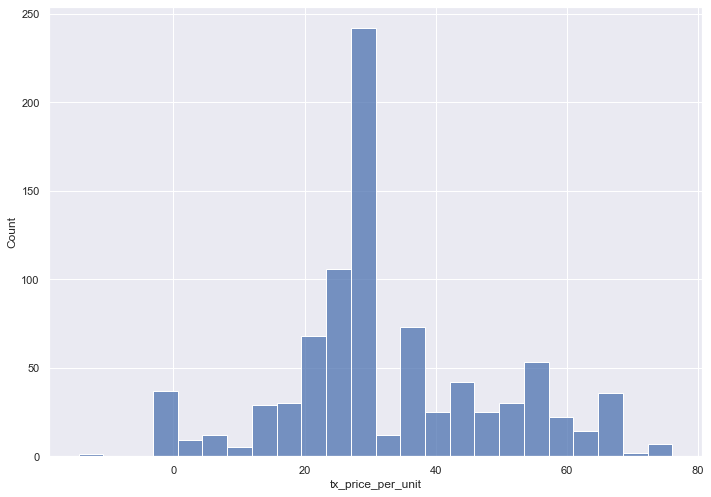

Extract (weight)
236


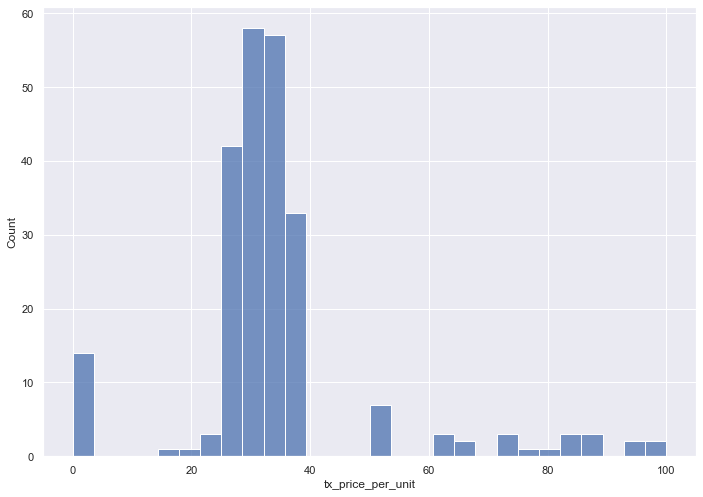

Seeds (each)
387


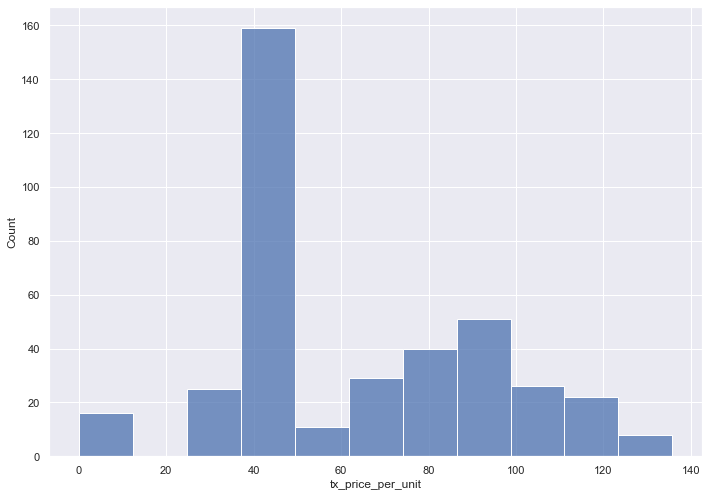

Pre-Roll Leaf
100799


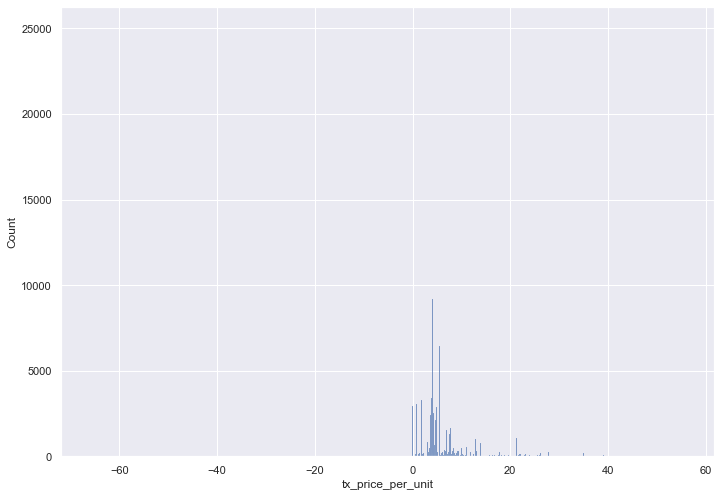

Other Concentrate (volume - each)
1584


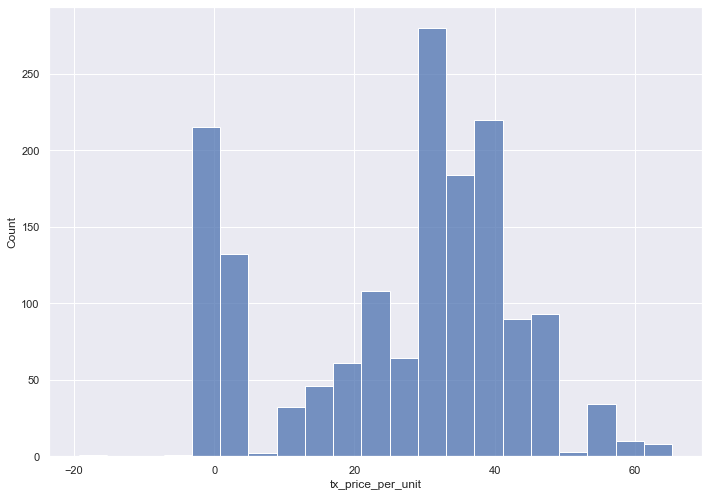

Tincture (volume)
9


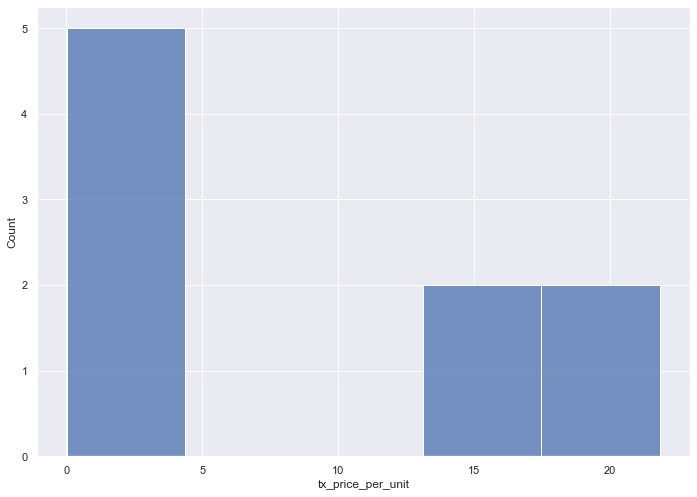

Vape Cartridge (weight - each)
249084


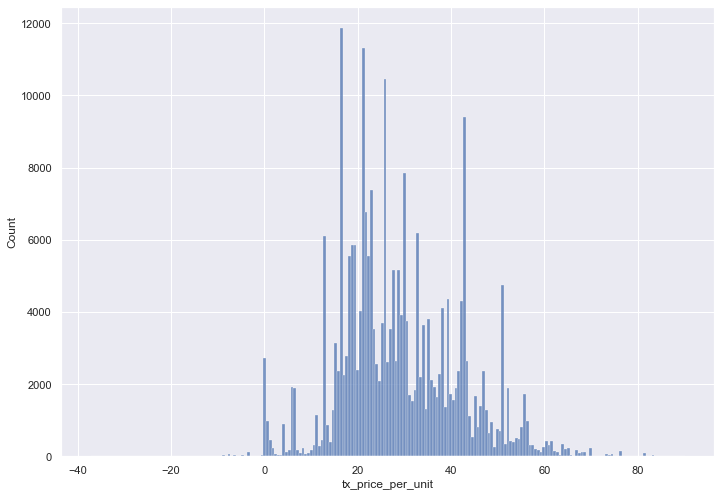

Flower (packaged eighth - each)
553992


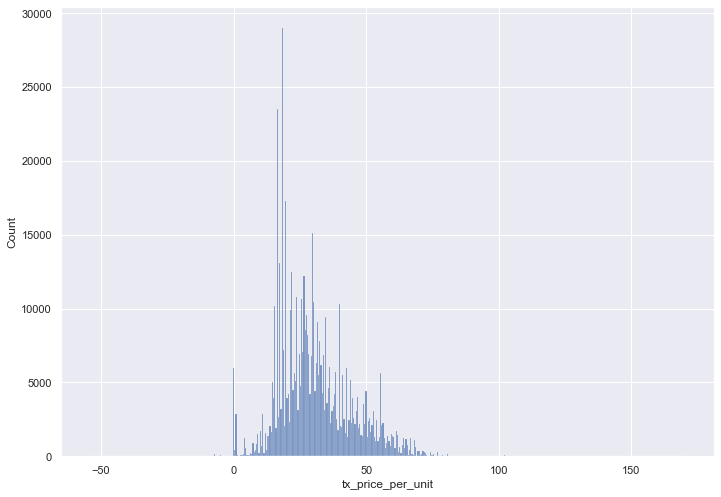

Clone - Cutting
301


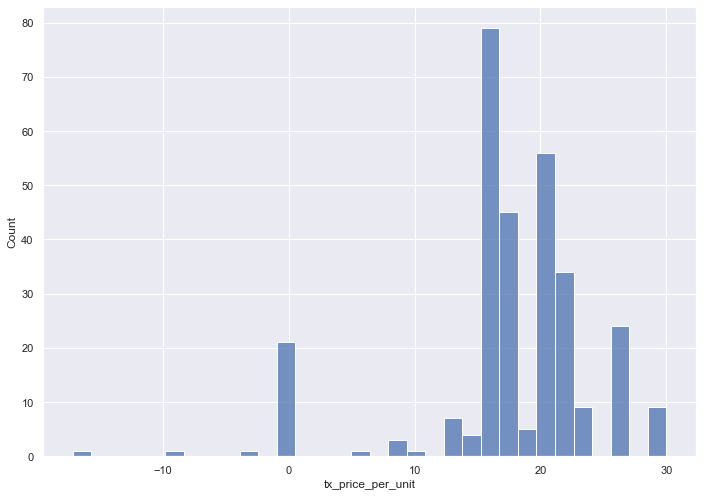

Flower (packaged half ounce - each)
32061


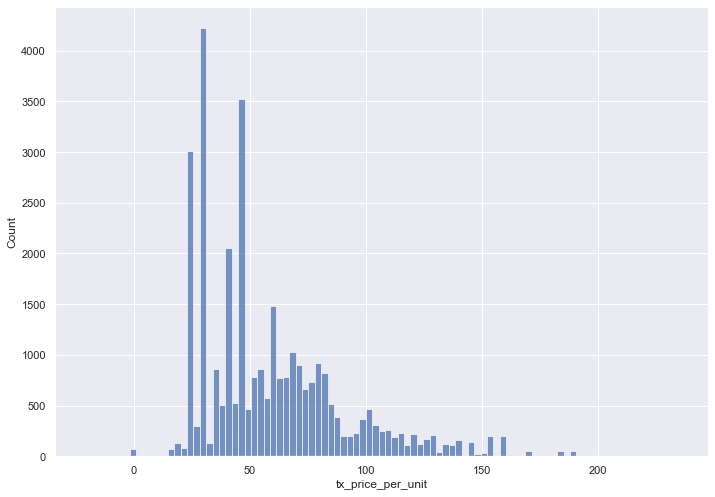

Flower (packaged gram - each)
21897


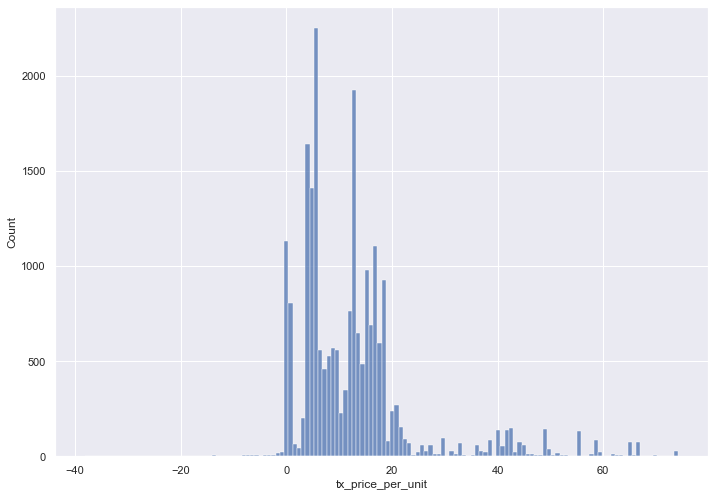

Flower (packaged quarter - each)
28536


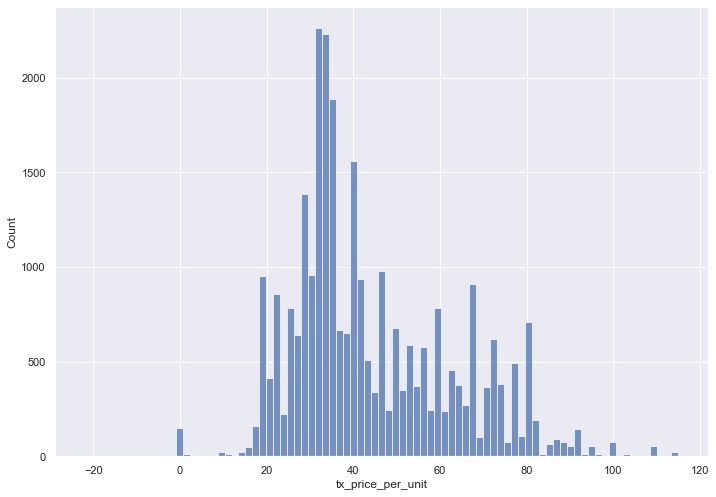

Kief
63


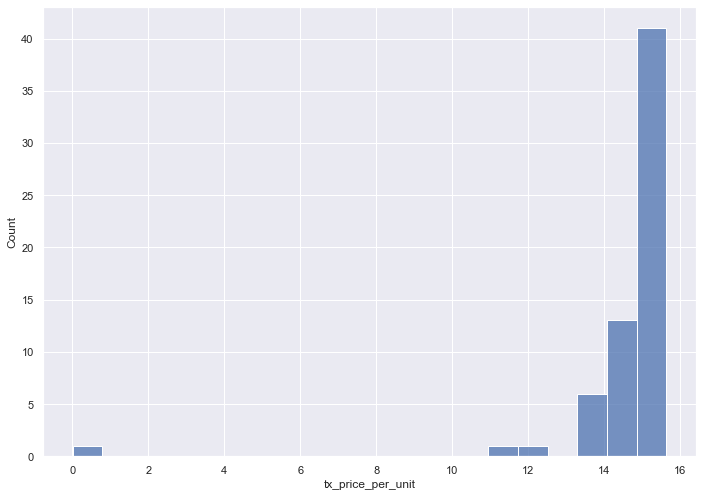

Shake (Packaged Quarter - each)
3483


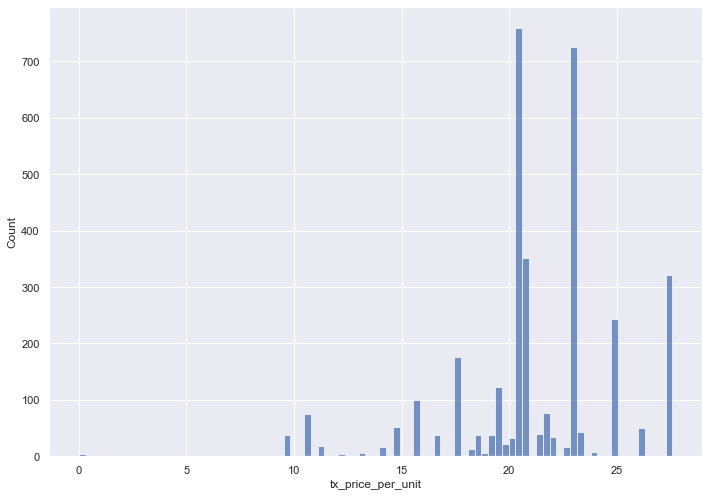

Flower (packaged ounce - each)
15538


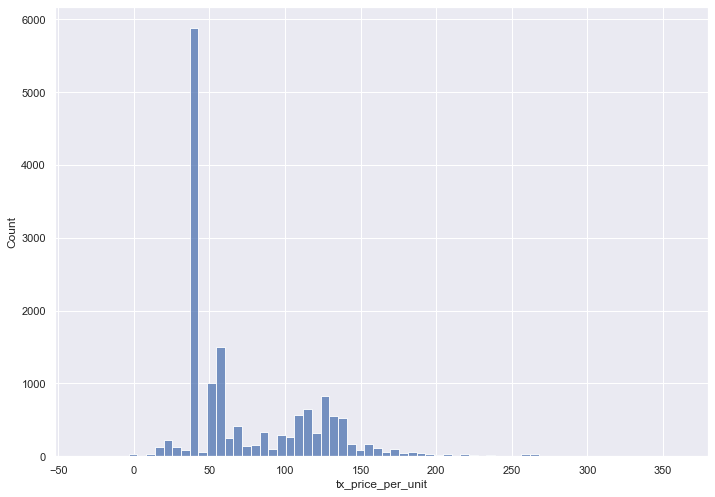

Shake (Packaged Half Ounce - each)
3459


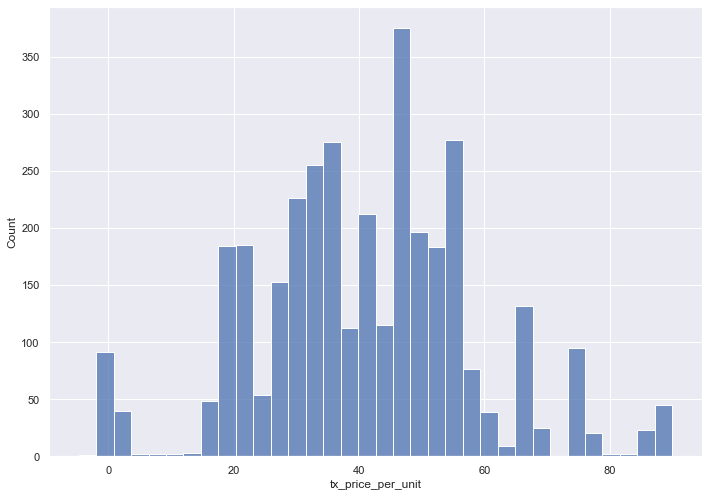

Immature Plant
32


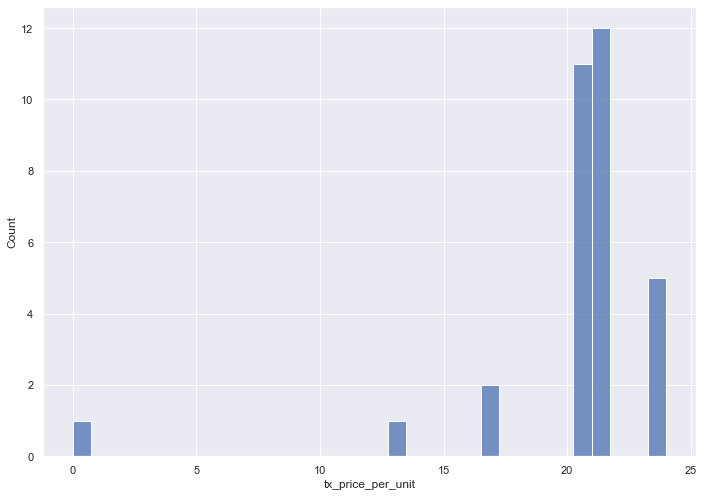

Shake
81


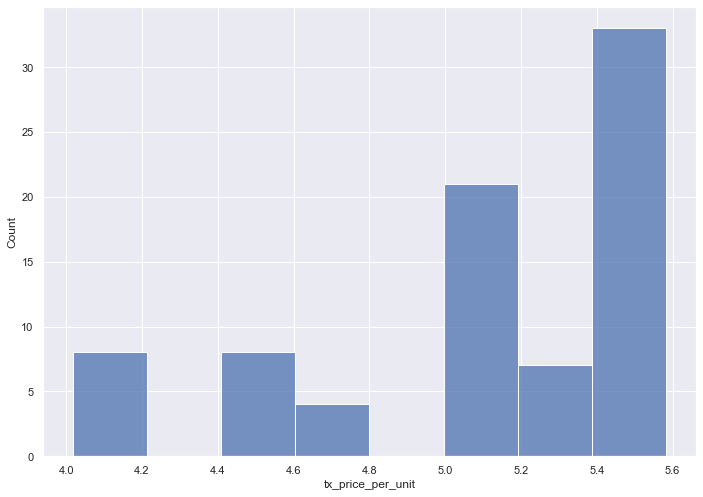

Shake (Packaged Eighth - each)
6543


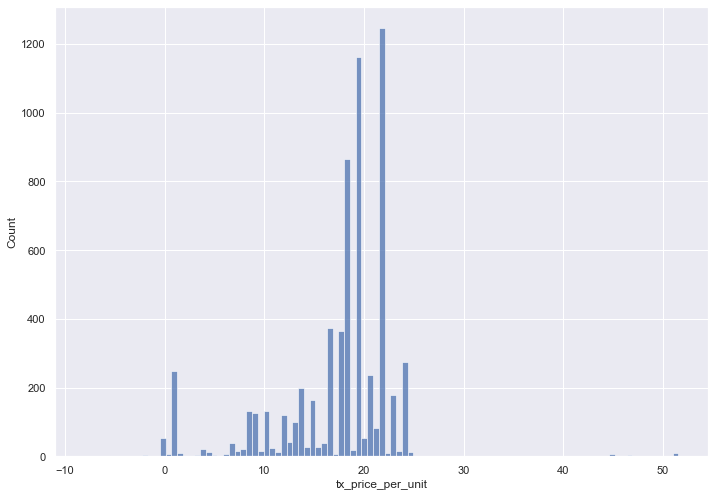

None
0


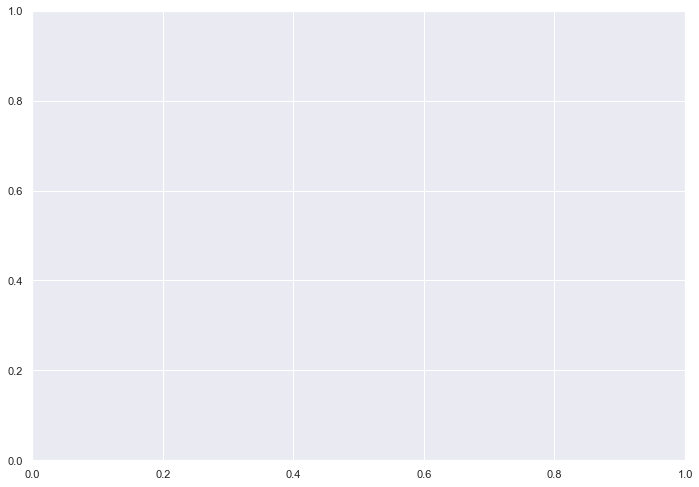

Shake (Packaged Gram - each)
1876


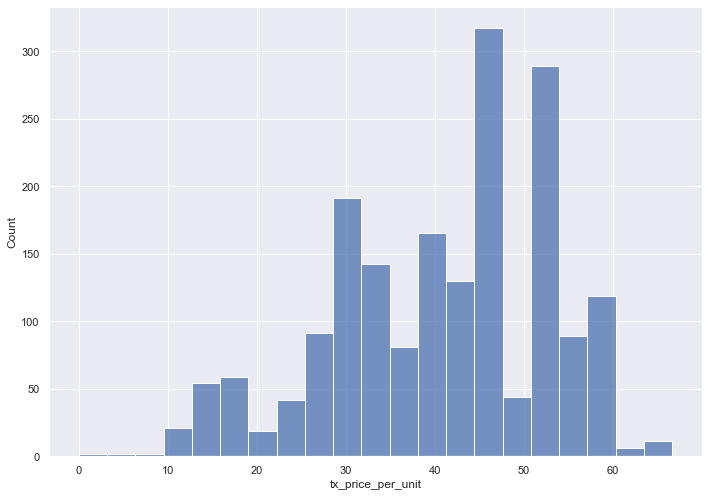

Other Concentrate (weight)
14


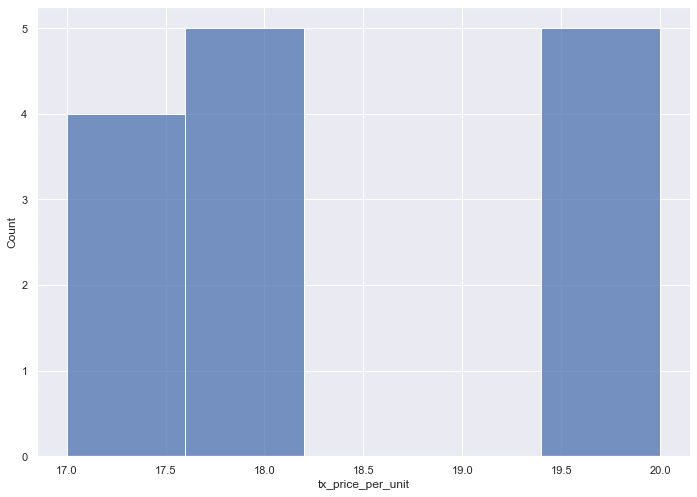

Tincture (weight - each)
799


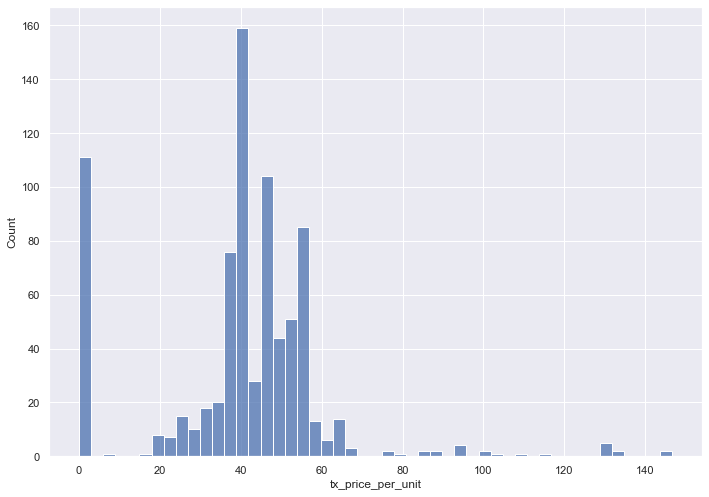

Flower (packaged - each)
8455


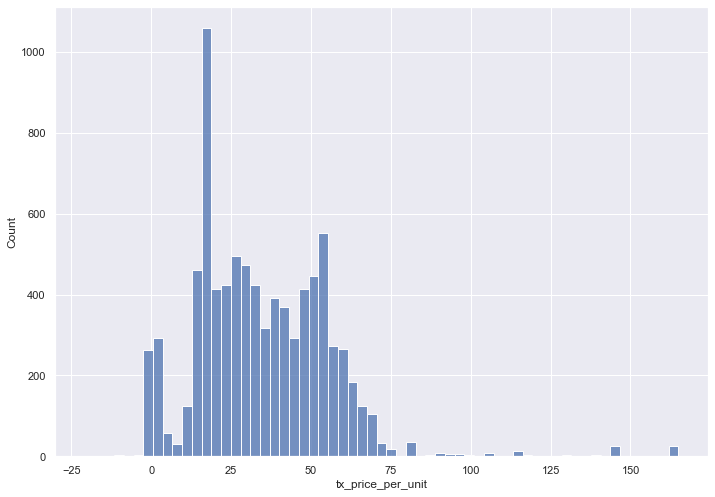

Shake (Packaged Ounce - each)
1062


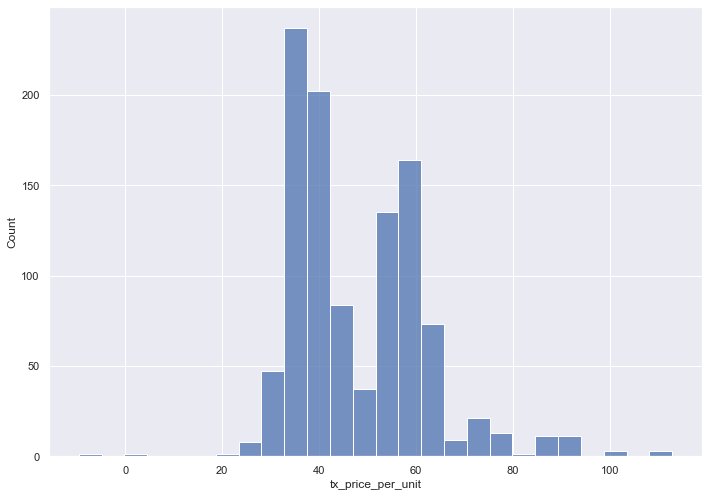

Infused Butter/Oil (weight - each)
270


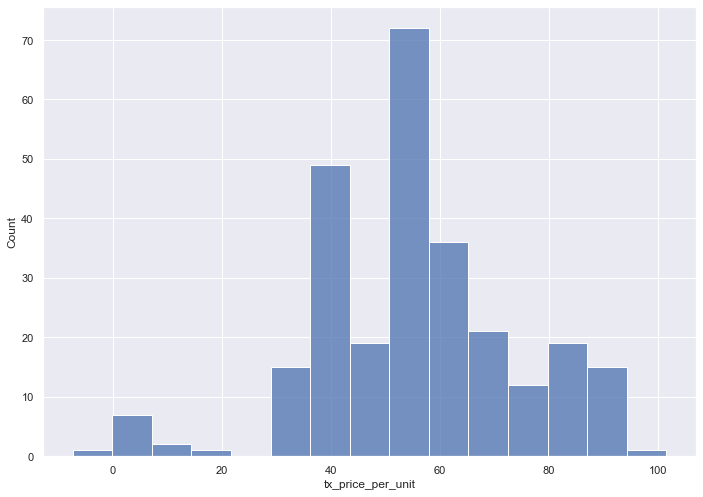

Infused Butter/Oil (volume - each)
10


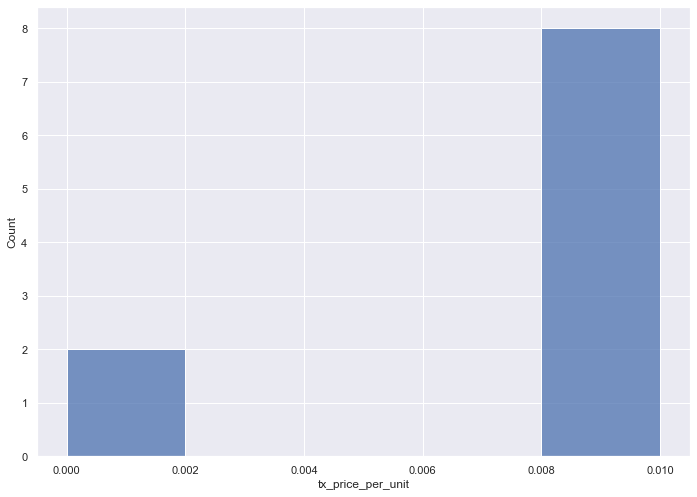

In [40]:
for product in sales_transaction_deduped.tx_product_category_name.unique():
    print(product)
    print(sum(sales_transaction_deduped.tx_product_category_name == product))
    sns.histplot(data=sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == product], x="tx_price_per_unit");
    plt.show()

In [41]:
msrp_tables = sales_transaction_deduped.groupby('tx_product_category_name')['tx_price_per_unit'].describe()#.unstack(1)
msrp_tables

,count,mean,std,min,25%,50%,75%,max
tx_product_category_name,,,,,,,,
Capsule (weight - each),6124.0,34.005786,23.398903,-29.720000,14.480000,36.530000,52.050000,121.500000
Clone - Cutting,301.0,17.684502,6.825087,-17.150000,16.320000,18.000000,21.320000,30.000000
Edible (volume - each),35063.0,12.009364,9.604915,-51.070000,6.300000,9.380000,15.350000,105.690000
Edible (weight - each),352894.0,14.945654,8.363495,-64.330000,9.280000,15.590000,20.280000,496.440000
Extract (volume - each),880.0,32.976353,16.291082,-14.440000,24.040000,29.850000,42.440000,76.090000
Extract (weight - each),163582.0,27.593188,14.526486,-40.840000,19.770000,26.120000,34.480000,138.800000
Extract (weight),236.0,34.859682,17.005719,0.000000,27.950000,31.450000,39.080000,100.000000
Flower,176671.0,10.049095,115.368929,-8.497143,5.320000,7.445714,10.088571,7291.428571
Flower (packaged - each),8455.0,34.881821,21.430388,-20.720000,18.390000,32.400000,49.850000,165.000000


In [42]:
msrp_tables.loc['Edible (weight - each)']

count    352894.000000
mean         14.945654
std           8.363495
min         -64.330000
25%           9.280000
50%          15.590000
75%          20.280000
max         496.440000
Name: Edible (weight - each), dtype: float64

In [43]:
msrp_by_month_product_name = sales_transaction_deduped.groupby(['tx_product_category_name', 'date_in_month'])['tx_price_per_unit'].describe()
msrp_by_month_product_name

count       mean        std  \
tx_product_category_name       date_in_month                                  
Capsule (weight - each)        2020-01           59.0  38.864322  22.066666   
                               2020-02           56.0  30.621131  20.723788   
                               2020-03           93.0  35.289810  23.601326   
                               2020-04           57.0  24.878787  21.587984   
                               2020-05           83.0  38.794618  23.497847   
...                                               ...        ...        ...   
Vape Cartridge (weight - each) 2021-10        23686.0  28.026063  12.247600   
                               2021-11        25522.0  28.279357  12.055595   
                               2021-12        28853.0  28.115315  12.212281   
                               2022-01        29169.0  28.216215  12.994532   
                               2022-02        23898.0  27.342882  13.307753   

                                                min     25%    50%      75%  \
tx_product_category_name       date_in_month                                  
Capsule (weight - each)        2020-01         0.00  17.380  38.71  51.4300   
                               2020-02         0.00  13.560  29.10  55.3000   
                               2020-03         0.00  13.820  35.30  55.3000   
                               2020-04         0.00   6.100  19.31  38.7100   
                               2020-05         0.00  26.265  38.71  53.2400   
...                                             ...     ...    ...      ...   
Vape Cartridge (weight - each) 2021-10       -30.46  19.590  25.66  37.6375   
                               2021-11       -34.74  19.660  25.66  37.6400   
                               2021-12       -35.70  19.960  25.64  36.1300   
                               2022-01       -28.72  19.660  25.64  38.2500   
                               2022-02       -27.03  18.620  23.49  38.2500   

                                                max  
tx_product_category_name       date_in_month         
Capsule (weight - each)        2020-01        77.17  
                               2020-02        64.37  
                               2020-03        87.36  
                               2020-04        86.90  
                               2020-05        86.90  
...                                             ...  
Vape Cartridge (weight - each) 2021-10        84.74  
                               2021-11        84.74  
                               2021-12        80.18  
                               2022-01        80.18  
                               2022-02        73.74  

[715 rows x 8 columns]

In [44]:
msrp_product_temp = msrp_by_month_product_name.loc['Edible (weight - each)']
msrp_product_temp

,count,mean,std,min,25%,50%,75%,max
date_in_month,,,,,,,,
2020-01,6777.0,15.224352,7.345560,0.00,12.7700,16.410000,19.54,62.67
2020-02,7413.0,14.858810,7.324804,0.00,11.4200,15.640000,19.54,70.97
2020-03,8816.0,15.349319,6.846699,0.00,12.4700,15.978333,18.85,96.55
2020-04,8996.0,14.488680,6.812316,0.00,11.2200,15.520000,18.62,62.97
2020-05,9095.0,14.243025,6.503285,0.00,11.0300,15.310000,17.82,70.97
2020-06,10203.0,14.877725,7.382767,0.00,11.0300,15.510000,19.54,96.55
2020-07,13407.0,15.482813,8.570980,0.00,10.4750,16.090000,20.69,129.93
2020-08,12422.0,15.892961,8.215727,0.00,11.0300,16.320000,20.69,129.93
2020-09,11431.0,15.988750,8.548438,-0.01,11.0300,16.710000,21.52,103.94


<AxesSubplot:xlabel='date_in_month'>

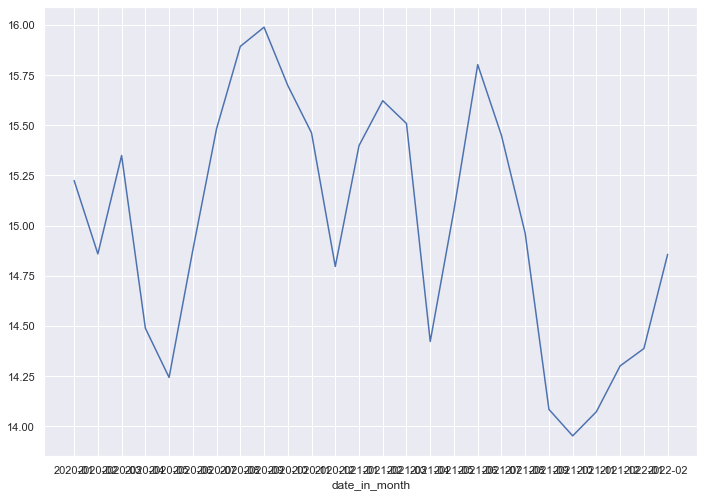

In [45]:
sns.lineplot(data = msrp_product_temp, x = msrp_product_temp.index, y = msrp_product_temp['mean'].values)

<AxesSubplot:xlabel='date_in_month', ylabel='tx_price_per_unit'>

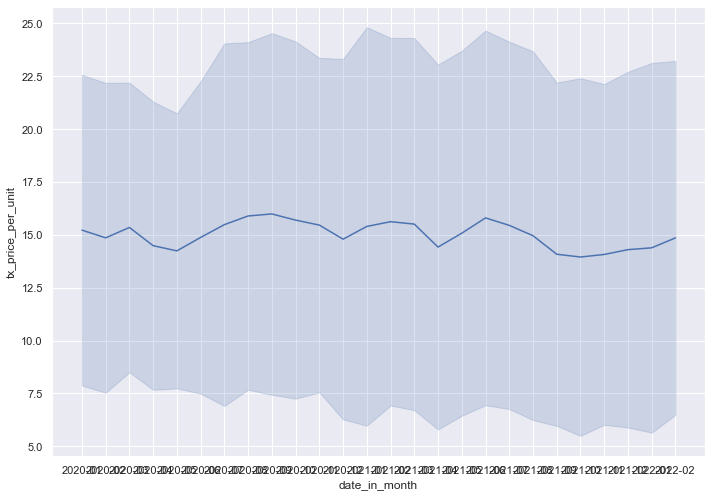

In [46]:
sns.lineplot(data = sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == 'Edible (weight - each)'], x = 'date_in_month', y = 'tx_price_per_unit',ci = 'sd')

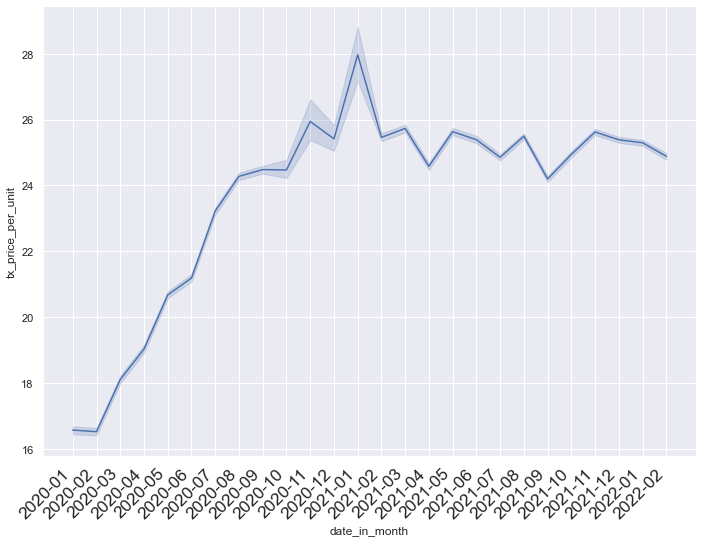

In [47]:
ax = sns.lineplot(data = sales_transaction_deduped, x = 'date_in_month', y = 'tx_price_per_unit',ci = 95,
                  err_style = 'band')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
plt.show()

# Step2

1. Add some functionality to combine some product categories that are similar but varies in unit (Flower packaged gram vs packaged half ounce) -- need to use regular expression
2. Add functionality for more granular product name/product brand breakdown on top of product category -- need regular expression for product brand

In [56]:
sales_transaction_deduped.tx_product_category_name.value_counts()

Flower (packaged eighth - each)        553992
Edible (weight - each)                 352894
Vape Cartridge (volume - each)         272641
Pre-Roll Flower                        264984
Vape Cartridge (weight - each)         249084
Flower                                 176671
Extract (weight - each)                163582
Pre-Roll Infused                       145759
Pre-Roll Leaf                          100799
Other Concentrate (weight - each)       59663
Edible (volume - each)                  35063
Flower (packaged half ounce - each)     32061
Flower (packaged quarter - each)        28536
Flower (packaged gram - each)           21897
Tincture (volume - each)                18756
Flower (packaged ounce - each)          15538
Flower (packaged - each)                 8455
Topical (weight - each)                  7671
Shake (Packaged Eighth - each)           6543
Capsule (weight - each)                  6124
Topical (volume - each)                  5677
Shake (Packaged Quarter - each)   

In [69]:
sales_transaction_deduped = sales_transaction_deduped[~sales_transaction_deduped.tx_product_category_name.isna()]

In [86]:
sales_transaction_deduped[sales_transaction_deduped.tx_product_category_name == 'Shake']

,license_number,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,tx_price_per_unit,date_in_month
2227351,C10-0000064-LIC,0040347222,inactive,Consumer,2020-08-06 17:59:51+00:00,2020-08,2,35.18,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,17.59,5.025714,2020-08
2227310,C10-0000064-LIC,0040347386,inactive,Consumer,2020-08-06 18:04:36+00:00,2020-08,2,39.08,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,19.54,5.582857,2020-08
2227054,C10-0000064-LIC,0040355290,inactive,Consumer,2020-08-06 18:39:20+00:00,2020-08,1,35.18,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,7.0,35.18,5.025714,2020-08
2227047,C10-0000064-LIC,0040355324,inactive,Consumer,2020-08-06 18:42:12+00:00,2020-08,3,70.44,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,15.63,4.465714,2020-08
2227009,C10-0000064-LIC,0040356370,inactive,Consumer,2020-08-06 18:47:47+00:00,2020-08,1,14.65,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,14.65,4.185714,2020-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220778,C10-0000064-LIC,0040637448,inactive,Consumer,2020-08-07 19:44:07+00:00,2020-08,2,40.06,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,16.61,4.745714,2020-08
2220755,C10-0000064-LIC,0040637653,inactive,Consumer,2020-08-07 19:45:32+00:00,2020-08,3,48.04,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,19.54,5.582857,2020-08
2220204,C10-0000064-LIC,0040777235,inactive,Consumer,2020-08-08 09:01:46+00:00,2020-08,3,90.33,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,10.5,43.95,4.185714,2020-08
2220086,C10-0000064-LIC,0040779786,inactive,Consumer,2020-08-08 09:25:54+00:00,2020-08,3,91.27,inactive,5902675,1A406030000390A000002710,Wedding Cake Smalls,Shake,Grams,3.5,19.54,5.582857,2020-08


In [89]:
sales_transaction_deduped.tx_product_category_name.str.contains('(?i)flower',  case = False).values

array([False,  True,  True, ..., False,  True,  True])

In [80]:
'Other Concentrate (weight - each) '.lower()

'other concentrate (weight - each) '

In [81]:
def product_category_standard_unit_conversion(category_name):
    result = category_name if '(' not in category_name else category_name.split('(')[0].strip()
    return result.lower()

In [87]:
sales_transaction_deduped.tx_product_category_name.apply(product_category_standard_unit_conversion)

2998033     vape cartridge
2998031             flower
2998029             flower
2998027             flower
2998024             flower
                ...       
4                   flower
3                   flower
2                   edible
1          pre-roll flower
0                   flower
Name: tx_product_category_name, Length: 2540936, dtype: object

In [82]:
product_category_standard_unit_conversion('Other Concentrate (weight - each) ')

'other concentrate'

In [60]:
sales_transaction_deduped.tx_unit_of_measure.value_counts()

Each            2363862
Grams            177065
Fluid Ounces          9
Name: tx_unit_of_measure, dtype: int64

# Step3

Final output for base analysis
1. Plots
2. Filtered data
3. Table with numbers

# Step4

Time series forecasting for future MSRP to understand future price trends